In [162]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [163]:
df = pd.read_csv('data\proposicoes_2013-2024_final_pres_cam.csv')
cols = [col for col in df.columns if col != 'VirouLei' and col != 'Partido_Pres_Cam'] + ['VirouLei'] + ['Partido_Pres_Cam']
df = df[cols]
df

,nomeProposicao,idProposicao,partidoAutor,DataApresentacao,Ano,Administração e Políticas Públicas,Desenvolvimento Social e Urbano,Direitos e Justiça,Economia e Desenvolvimento Sustentável,Infraestrutura e Gestão de Recursos,Influencia,Aliado,Oposição,PPC_igual_partidoAutor,VirouLei,Partido_Pres_Cam
0,PL 4926/2013,564574,PR,2013-02-04,2013,0,1,0,0,0,0.077973,1,0,0,0,PMDB
1,PL 4931/2013,564595,PR,2013-02-04,2013,1,1,0,0,1,0.024691,1,0,0,0,PMDB
2,PL 4928/2013,564579,PSB,2013-02-04,2013,0,1,0,0,0,0.025341,1,0,0,0,PMDB
3,PL 4936/2013,564610,PR,2013-02-05,2013,0,0,0,1,0,0.148148,1,0,0,0,PMDB
4,PL 4937/2013,564611,PSD,2013-02-05,2013,0,0,0,1,0,0.033138,1,0,0,0,PMDB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7956,PL 3027/2024,2450707,PT,2024-08-02,2024,0,0,0,1,1,0.097466,1,0,0,1,PP
7957,PL 3117/2024,2452037,PT,2024-08-13,2024,1,0,0,0,0,0.083821,1,0,0,1,PP
7958,PL 3148/2024,2452628,PSB,2024-08-13,2024,0,1,0,0,0,0.132554,1,0,0,1,PP
7959,PL 3266/2024,2454377,UNIÃO,2024-08-21,2024,0,1,0,1,0,0.011696,1,0,0,0,PP


- Pré-processamento

In [257]:
df_2024 = df[df['Ano'] == 2024]
df = df[df['Ano'] != 2024]

In [258]:
df['VirouLei'].value_counts()

VirouLei
0    7184
1     757
Name: count, dtype: int64

- Undersampling

In [259]:
colunas = df.columns.tolist()

In [260]:
x = df[colunas[5:-2]]
y = df[colunas[-2]]

In [261]:
undersample = RandomUnderSampler(sampling_strategy=1.0) #para igualar as classes
#undersample = RandomUnderSampler(sampling_strategy=0.428) #70% 30%
#undersample = RandomUnderSampler(sampling_strategy=0.690)

x_sample, y_sample = undersample.fit_resample(x, y)

In [262]:
y_sample.value_counts()

VirouLei
0    757
1    757
Name: count, dtype: int64

- Random Forest

In [263]:
x_train, x_test, y_train, y_test = train_test_split(x_sample, y_sample, test_size=0.3, random_state=42)

- Entendendo melhor numero de estimadores para os meus dados

In [264]:
param_grid = {
    'n_estimators': [30, 50, 100, 150, 200], 
}

rf_classifier = RandomForestClassifier(max_depth=5, random_state=42)
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(x_train, y_train)

print("Melhor número de estimadores:", grid_search.best_params_['n_estimators'])


Melhor número de estimadores: 50


- Seguindo com o melhor número + ajuste de profundidade

In [265]:
rf = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'], max_depth=5, random_state=42)


rf.fit(x_train, y_train)
y_prob = rf.predict_proba(x_test)[:,1]
y_pred = rf.predict(x_test)

y_treino_pred = rf.predict(x_train)

rf_acuracia = accuracy_score(y_test, y_pred)
rf_acuracia_treino = accuracy_score(y_train, y_treino_pred)
print('Acuracia treino: ', rf_acuracia_treino)
print('Acuracia: ', rf_acuracia)

Acuracia treino:  0.6553352219074599
Acuracia:  0.589010989010989


- Avaliação

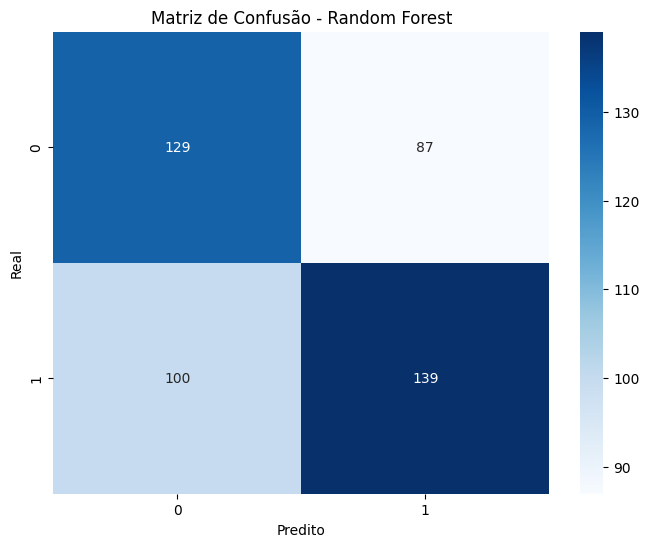

In [266]:

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Random Forest')
plt.show()


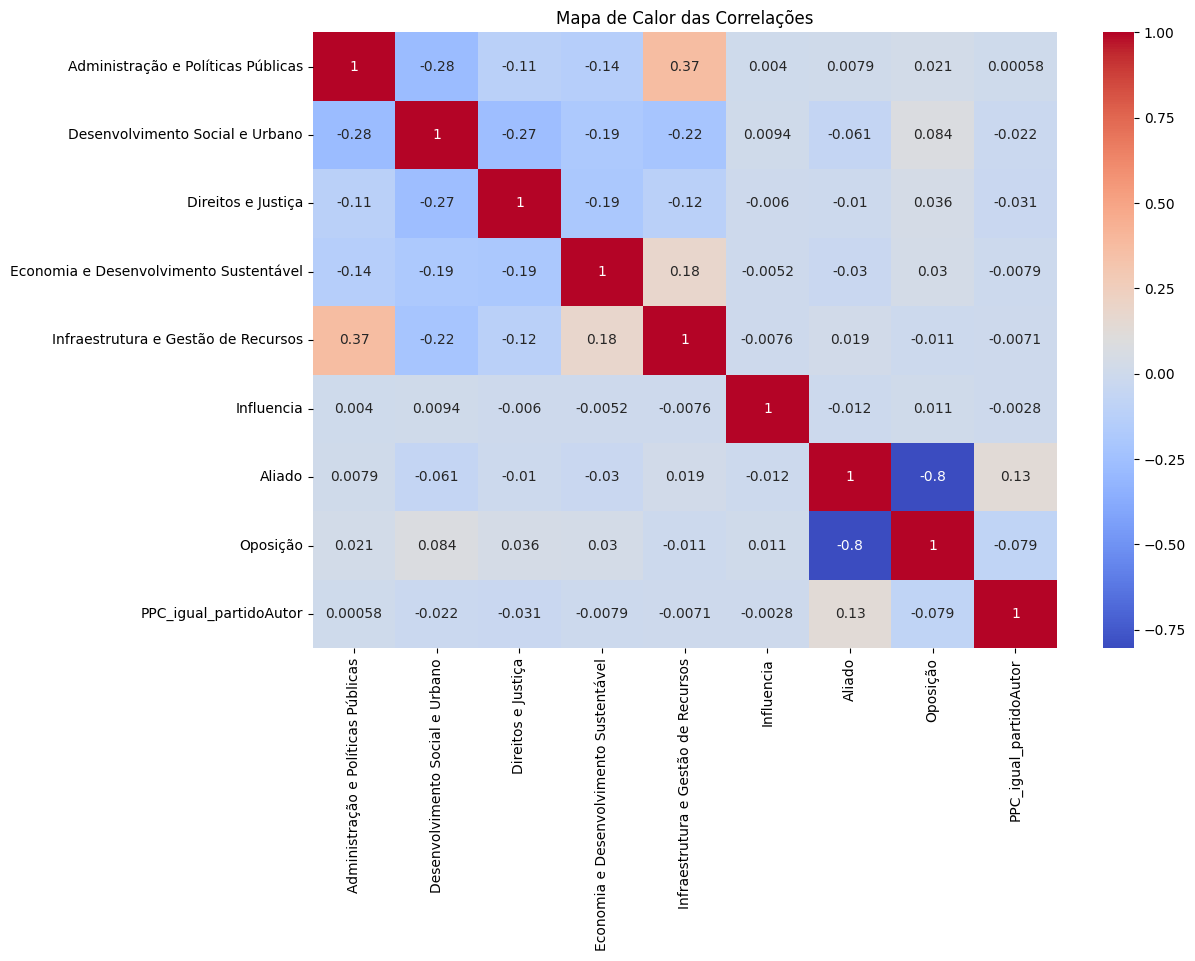

In [267]:
correlation_matrix = x.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Mapa de Calor das Correlações')
plt.show()

                                  Feature  Importance
5                              Influencia    0.288908
1         Desenvolvimento Social e Urbano    0.208589
0      Administração e Políticas Públicas    0.154631
3  Economia e Desenvolvimento Sustentável    0.116789
2                      Direitos e Justiça    0.060385
4     Infraestrutura e Gestão de Recursos    0.050101
8                  PPC_igual_partidoAutor    0.047609
6                                  Aliado    0.037637
7                                Oposição    0.035351


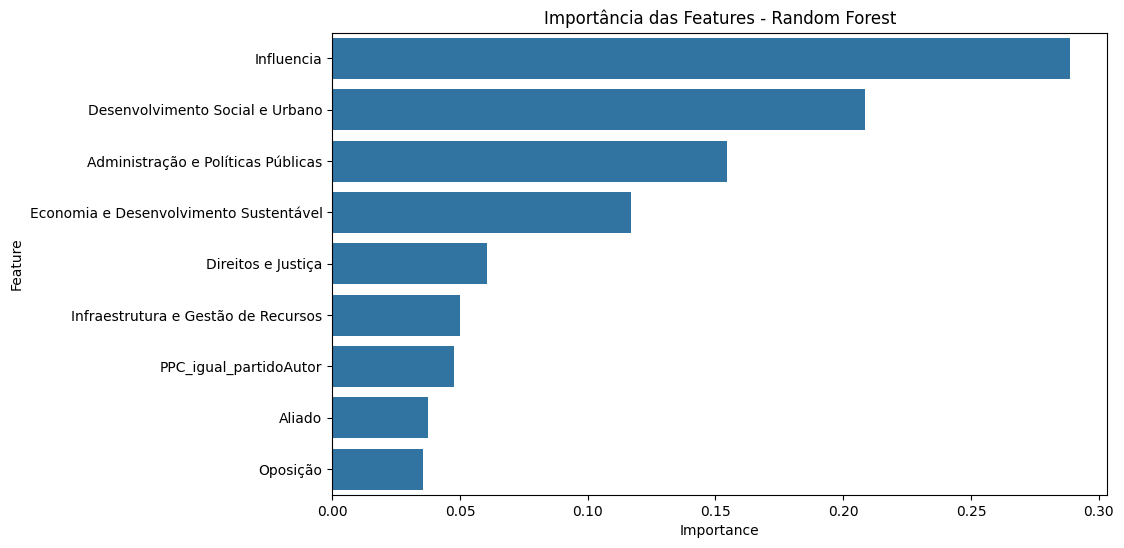

In [268]:
importances = rf.feature_importances_
feature_names = x.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importância das Features - Random Forest')
plt.show()


- Conclusão

In [272]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)

principal_components

array([[ 0.35954996,  0.75594119],
       [ 0.45271322,  0.18273402],
       [ 0.35959315,  0.75591799],
       ...,
       [ 0.55817257, -0.40485762],
       [ 0.59353825, -0.39623082],
       [ 0.37572863,  0.3947878 ]])

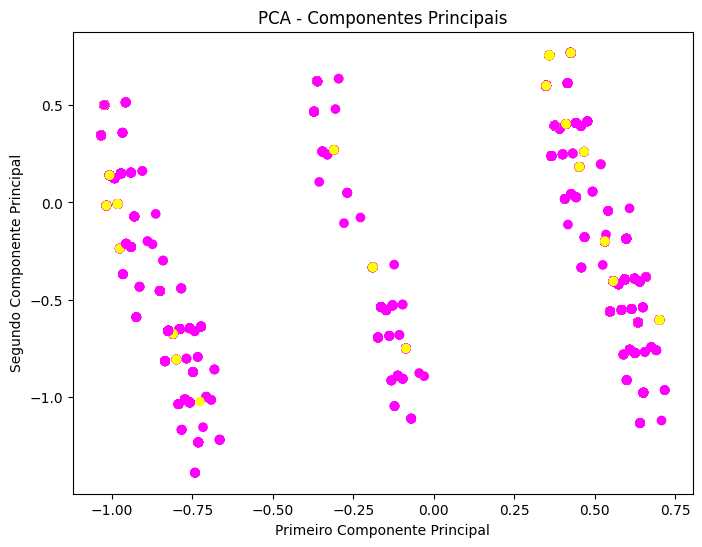

In [293]:
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=y, cmap='spring')
plt.title('PCA - Componentes Principais')
plt.xlabel('Primeiro Componente Principal')
plt.ylabel('Segundo Componente Principal')
plt.show()

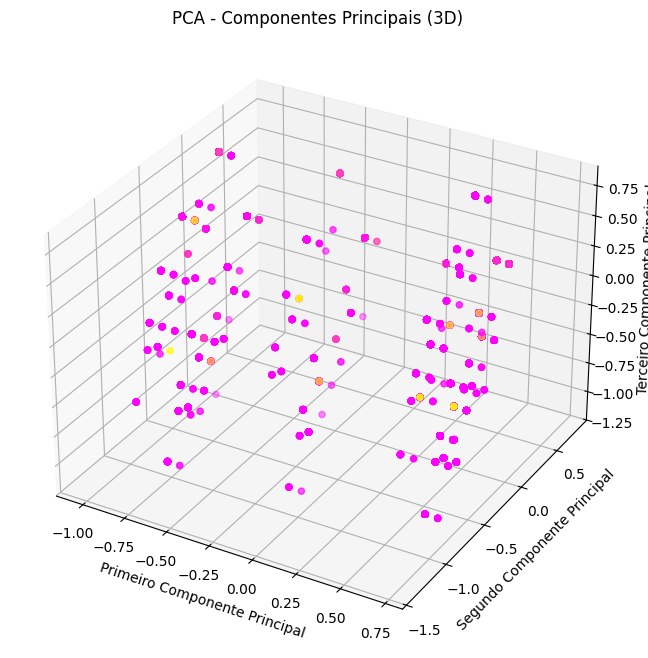

In [292]:
pca3 = PCA(n_components=3) 
principal_components = pca3.fit_transform(x)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2], c=y, cmap='spring')
ax.set_title('PCA - Componentes Principais (3D)')
ax.set_xlabel('Primeiro Componente Principal')
ax.set_ylabel('Segundo Componente Principal')
ax.set_zlabel('Terceiro Componente Principal')
plt.show()

Após a implementação e otimização da árvore de decisão, e da random forest, alcançamos uma acurácia máxima de aproximadamente 60%. 

Embora tenhamos limitado o overfitting e melhorado a generalização do modelo, a acurácia ainda é insatisfatória. 

A partir de uma análise aprofundada nos dados, identificamos um possível desbalanceamento de classes e uma relevância insuficiente das features, o que provavelmente é o que está impactando o desempenho do modelo. 

A natureza complexa do problema, aliada à qualidade e quantidade dos dados, pré e pós balanceamento, limita nossa capacidade de alcançar resultados melhores. Para futuras iterações, pretendemos coletar mais dados, considerando buscar features com maior correlação com o objetivo de melhorar o aprendizado.